## Python statistics essential training - 05_06_bayesian

The last topic in this course is Bayesian inference, a type of statistical inference that has been gaining more and more interest and adoption over the last few decades. Of course I won't be able to do it justice in a few minutes, but I wanted to at least introduce it because it's the kind of statistics that I do every day in my job. I hope I can at least make you curious to learn about it elsewhere.

Bayesian inference takes a very different viewpoint from anything else we've seen so far. Instead of estimating from the data a single value for the population parameters, we characterize them with entire **probability distributions** which represent our knowledge and our uncertainty about them.

So we start with the **prior probability** which represents what we already know about the parameters, if anything. We make **observations**, and we use the observations to update the prior into **posterior probability**.

Here's a silly example. Suppose my cat hid behind one of two doors, I don't know which, so my priors were probability of 50% for each door. If however, I observe the tail, I'm able to update these probabilities to 100% for door one, and 0% for door two.

![Hidden cat example](hidden_cat.png "Hidden cat")

For more general distributions, the update rule is called Bayes' Theorem, and it involves multiplying the prior by the likelihood.

![Bayes theorem](bayes.png "Bayes theorem")

The likelihood describes the observations, how likely they are, given a certain value of the parameters.

This simple rule is sufficient to generate 90% of Bayesian inference, but the computation may be hard, and in fact, before computers, it was too hard for many statisticians to take Bayesian inference seriously.

So what can we do with Python?
I'm going to introduce a very powerful package for Bayesian inference, pymc3.

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import pymc3 as pm

I'm going to do a classic Bayesian problem.

I have a single coin and I'm suspicious that it's not fair, that is, throwing it repeatedly may return heads between 40% and 80% of the time instead of 50%. So I have thrown the coins 100 times, and I found 61 heads.

In [6]:
n = 100
k = 61

with pm.Model() as coin_context:
    # p is the actual fraction that heads comes up for this coin
    # My prior for it is that it's uniformly distributed between 40% and 80%
    p = pm.Uniform('p', 0.40, 0.80)
    
    # Actual observations
    # The binomial distribution describes the probability of observing k events
    # over n trials if each event has a probability p. 
    y = pm.Binomial('y', n=n, p=p, observed=k)
    
    
    # Sample the posterior
    # we ask pymc3 to generate a large set of population parameters
    # which will be approximately distributed according to the posterior
    # This set of parameters is called a trace
    trace = pm.sample(10000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 59 seconds.


Pymc3 may take a little while to do the sampling, especially the first time.

Now I can ask it to summarize the posterior for me.

In [7]:
pm.summary(trace)

C:\Users\RafaelPinto\AppData\Local\Anaconda3\envs\springboard\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.607,0.048,0.518,0.698,0.001,0.0,8551.0,8551.0,8565.0,12275.0,1.0


The mean is 60%, that's the most probable value for the bias-ness of the coin, and the standard deviation is about 5%. The hpd, delimited credible interval, analog to a confidence interval, containing 95% of the probability.

Pymc3 can also do a nice traceplot.

C:\Users\RafaelPinto\AppData\Local\Anaconda3\envs\springboard\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

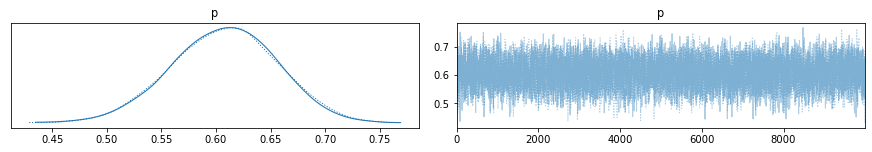

In [8]:
pm.traceplot(trace)

There are two curves here, because pymc3 ran two separate samplings. The plot on the right shows all the values taken on by the parameter, p.

Now we move on to Bayesian statistical modeling, and once again, we consider the gapminder data for child survival and babies per woman.

In [9]:
gdata = pd.read_csv('gapminder.csv').query('year == 1985')

To plot it better, I will sort the data by `age5_surviving` value.

In [10]:
gdata.sort_values('age5_surviving', inplace=True)

 Let's do a very quick, very simple-minded plot.

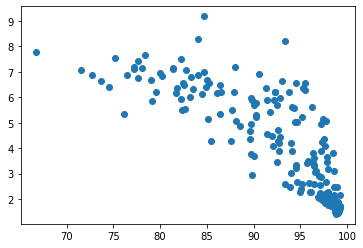

In [11]:
pp.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

This downward trend is what we'll need to reproduce. So I will put together a very simple model, just a intercept, and a main term, a slope, for `age5_surviving`.

In [17]:
with pm.Model() as gapminder_context:
    # For the intercept, I can figure out from the plot, that there should be about 10
    # where survival is 65%, so I will have a uniform prior between 5 and 15
    intercept = pm.Uniform('intercept', 5, 15)
    
    # For the slope, I can again figure out from the plot, that it should be somewhere
    # around a few tenths. So let's do -1 to 1.
    slope = pm.Uniform('slope', -1, 1)
    
    # The observations will be normally distributed around the model, i.e.
    # I allow each data value to have a random measurement error with normal distribution
    # This is the simplest, most likely hypothesis. Errors are very important in Bayesian inference
    babies = pm.Normal('babies',
                      mu = intercept + slope * (gdata['age5_surviving'] - 65),
                      sd = 1,  # std of the measurement error
                      observed = gdata['babies_per_woman'])
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [slope, intercept]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 64 seconds.
The acceptance probability does not match the target. It is 0.889128964435777, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


So here's the summary and the traceplot.

In [18]:
pm.summary(trace)

C:\Users\RafaelPinto\AppData\Local\Anaconda3\envs\springboard\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,10.194,0.278,9.674,10.709,0.005,0.004,3154.0,3146.0,3146.0,4485.0,1.0
slope,-0.219,0.010,-0.238,-0.200,0.000,0.000,3170.0,3157.0,3162.0,4494.0,1.0


C:\Users\RafaelPinto\AppData\Local\Anaconda3\envs\springboard\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

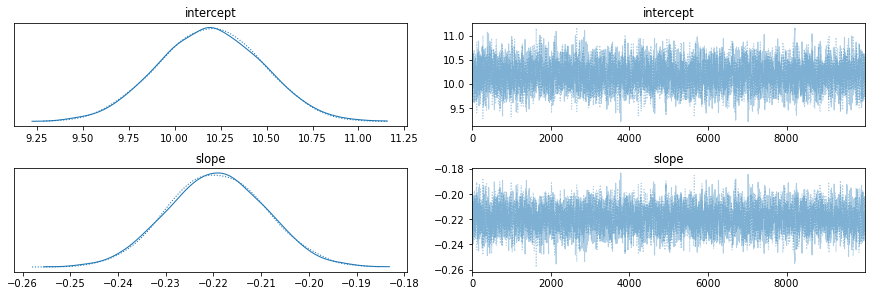

In [19]:
pm.traceplot(trace)

The posteriors are centered a little above 10 for the intercept, and close to minus 0.22 for the slope. We have a very good control over the uncertainty of the parameters.

Evaluated at the mean of the posterior, the model would look like this:

In [20]:
babies = trace['intercept'].mean() + trace['slope'].mean()*(gdata['age5_surviving'] - 65)

I will plot over the data. And that's our Bayesian fit.

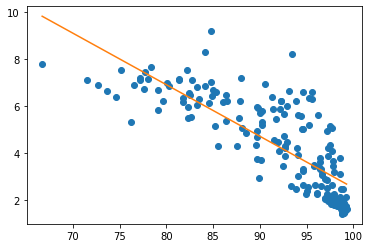

In [21]:
pp.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])
pp.plot(gdata['age5_surviving'], babies, 'C1')

In fact, every point in the posterior corresponds to a slightly different model. We can plot them all together to visualize uncertainty.

Let me copy some code, the data again, and then I will loop over points in the posterior.

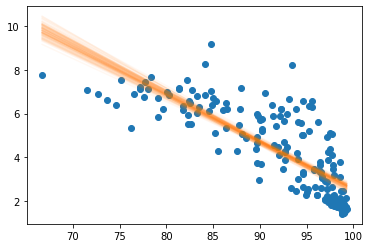

In [24]:
pp.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

# Take every 50th point and also stop the iteration after 100 points.
# I can do that by adding another iterator here, range to 100, and also i to catch it.
for i, intercept, slope, in zip(range(100), trace['intercept'][::50], trace['slope'][::50]):
    babies = intercept + slope * (gdata['age5_surviving'] - 65)
    pp.plot(gdata['age5_surviving'], babies, 'C1', alpha=0.05)

Here is my bundle of models within the posterior. And that's all folks.